In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot

In [2]:
df = pd.read_pickle('Data/Capstone_Milestone.pkl')
df = df.reset_index(level='State')
df['State'] = df['State'].astype('category')
df = pd.get_dummies(df, drop_first=True)
X = df.drop(df.columns[1:5], axis=1)
y = df.iloc[:, 4].copy()

In [3]:
# I ran this once to create the holdout sets and save them. This way rerunning the notebook should give similar results.

# X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3)
# X_test, X_final, y_test, y_final = train_test_split(X_holdout, y_holdout, test_size=0.5)

# X_train.to_pickle('Data/X_train.pkl')
# X_test.to_pickle('Data/X_test.pkl')
# X_final.to_pickle('Data/X_final.pkl')
# y_train.to_pickle('Data/y_train.pkl')
# y_test.to_pickle('Data/y_test.pkl')
# y_final.to_pickle('Data/y_final.pkl')

In [4]:
X_train = pd.read_pickle('Data/X_train.pkl')
X_test = pd.read_pickle('Data/X_test.pkl')
X_final = pd.read_pickle('Data/X_final.pkl')
y_train = pd.read_pickle('Data/y_train.pkl')
y_test = pd.read_pickle('Data/y_test.pkl')
y_final = pd.read_pickle('Data/y_final.pkl')

In [5]:
# For the linear regressions, the features should be scaled.
scaler = RobustScaler()
X_lin_train = scaler.fit_transform(X_train)
X_lin_test = scaler.transform(X_test)

In [6]:
def rmse_score(reg, X, y):
    y_pred = reg.predict(X)
    return math.sqrt(mean_squared_error(y, y_pred))

In [7]:
y_stats = pd.DataFrame({'train': y_train.describe(),
                         'test': y_test.describe(),
                         'final': y_final.describe()})
y_stats

,train,test,final
count,2197.000000,471.000000,471.000000
mean,2.870791,2.826476,3.042433
std,1.986789,1.880721,2.484606
min,0.000000,0.000000,0.000000
25%,1.666667,1.664414,1.666667
50%,2.428571,2.400000,2.428571
75%,3.500000,3.500000,3.454546
max,17.000001,15.000000,17.000001


### Regressions on dataset before feature engineering
I will start by calculating the RMSE of using the mean as the predicted value.

In [8]:
y_pred = np.full_like(y_test, y_train.mean())
print(math.sqrt(mean_squared_error(y_test, y_pred)))

1.8792459387068994


As a baseline, I will start with simple linear regression and the regularized versions: lasso, ridge, and elastic net as well as random forest and gradient boosting.

In [9]:
linear = LinearRegression()
lasso = LassoCV(alphas=[1e-2, 1e-1, 1, 10], cv=10)
ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv=10)
elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[1e-2, 1e-1, 1, 10], cv=10, n_jobs=-1)
regs = {'Linear': linear, 'Lasso': lasso, 'Ridge': ridge, 'Elastic Net': elastic}

for name, reg in regs.items():
    reg.fit(X_lin_train, y_train)
    print(name, rmse_score(reg, X_lin_test, y_test))

Linear 1.7751628028034354
Lasso 1.789733030701339
Ridge 1.7787517809491153
Elastic Net 1.7846812885108256


In [10]:
rf = RandomForestRegressor(n_estimators=100, max_features='sqrt')
rf.fit(X_train, y_train)
print(rmse_score(rf, X_test, y_test))

1.7631574399753207


In [11]:
gb = GradientBoostingRegressor(max_features='sqrt', max_depth=1)
gb.fit(X_train, y_train)
print(rmse_score(gb, X_test, y_test))

1.7586215635526257


Smaller root mean squared errors (RMSE) are better, but there is no absolute scale to determine what a good RMSE is. I have found two ways people have used to assess RMSE scores. The first is to compare it to the standard deviation of the test set. The second is to compare it to the RMSE of using the mean of the train set as the predicted value. For this test set both are ~1.88. After looking at the math of these methods, I realized that these are the same equation excpet the first uses the mean of the test set and the second, the mean of the train set so the values should be similar.  
With this method of determining goodness of fit, none of these models preform all that well, but the best is definietly gradient boosting.

### Feature selection and engineering
#### Income features
In the dataset there is a feature that contains the median household income in each county and there is also a set of features that represent the percentage of income tax filings in each of 8 ranges. I will investigate if these are interacting in a way that effects the fit of the models.

In [12]:
# Remove the household income column
X_tax_train = X_train.loc[:, X_train.columns!='medhhinc15']
X_tax_test = X_test.loc[:, X_test.columns!='medhhinc15']
# Remove the tax bracket columns
X_inc_train = X_train.drop(X_train.columns[14:22], axis=1)
X_inc_test = X_test.drop(X_test.columns[14:22], axis=1)

In [13]:
gb1 = GradientBoostingRegressor(max_features='sqrt', max_depth=1)
gb1.fit(X_tax_train, y_train)
print(rmse_score(gb1, X_tax_test, y_test))

1.750959130575095


In [14]:
gb2 = GradientBoostingRegressor(max_features='sqrt', max_depth=1)
gb2.fit(X_inc_train, y_train)
print(rmse_score(gb2, X_inc_test, y_test))

1.7590728607887856


These models perform similarly to the models with all of the features.

#### Interaction terms
I will use the PolynomialFeatures function to create interaction terms as well as squares of the features.

In [15]:
poly = PolynomialFeatures(2)
poly_X_train = poly.fit_transform(X_train.iloc[:, :22])
poly_X_test = poly.transform(X_test.iloc[:, :22])
X_poly_train = (pd.DataFrame(poly_X_train, columns=poly.get_feature_names(X_train.columns), index=X_train.index)
               .merge(X_train.iloc[:, 22:], left_index=True, right_index=True))
X_poly_test = (pd.DataFrame(poly_X_test, columns=poly.get_feature_names(X_test.columns), index=X_test.index)
               .merge(X_test.iloc[:, 22:], left_index=True, right_index=True))

In [16]:
gb3 = GradientBoostingRegressor(max_features='sqrt', max_depth=1)
gb3.fit(X_poly_train, y_train)
print(rmse_score(gb3, X_poly_test, y_test))

1.7665373345322435


This seems to have increased the RMSE so I will not use these features in the hyperparameter tuning.

### Hyperparameter tuning

In [17]:
parameters = {'n_estimators': [50, 100, 200],
              'max_features': ['sqrt', 0.5, None],
              'max_depth': [1, 3, 5]}
gb_grid = GridSearchCV(GradientBoostingRegressor(), 
                       scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False)},
                       param_grid=parameters, 
                       refit='MSE',
                       cv=10, 
                       n_jobs=-1,
                       iid=False)
gb_grid.fit(X_train, y_train)
print(rmse_score(gb_grid, X_test, y_test))

1.789590227478346


In [18]:
sorted(list(zip(gb_grid.cv_results_['rank_test_MSE'], 
                np.sqrt(np.abs(gb_grid.cv_results_['mean_test_MSE'])).round(4), 
                gb_grid.cv_results_['params'])))[:5]

[(1, 1.8678, {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}),
 (2, 1.8766, {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}),
 (3, 1.8779, {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 200}),
 (4, 1.8781, {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}),
 (5, 1.8834, {'max_depth': 1, 'max_features': 'sqrt', 'n_estimators': 100})]

The best max_features is clearly sqrt. The other two parameters are unclear.

In [19]:
parameters = {'n_estimators': [50, 100, 200],
              'max_depth': [1, 3, 5]}
gb_grid = GridSearchCV(GradientBoostingRegressor(max_features='sqrt'), 
                       scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False)},
                       param_grid=parameters,
                       refit='MSE',
                       cv=10, 
                       n_jobs=-1,
                       iid=False)
gb_grid.fit(X_train, y_train)
print(rmse_score(gb_grid, X_test, y_test))

1.758618557214056


In [20]:
sorted(list(zip(gb_grid.cv_results_['rank_test_MSE'], 
                np.sqrt(np.abs(gb_grid.cv_results_['mean_test_MSE'])).round(4), 
                gb_grid.cv_results_['params'])))

[(1, 1.863, {'max_depth': 3, 'n_estimators': 50}),
 (2, 1.8777, {'max_depth': 3, 'n_estimators': 100}),
 (3, 1.8779, {'max_depth': 3, 'n_estimators': 200}),
 (4, 1.8779, {'max_depth': 1, 'n_estimators': 200}),
 (5, 1.8848, {'max_depth': 5, 'n_estimators': 100}),
 (6, 1.8886, {'max_depth': 1, 'n_estimators': 100}),
 (7, 1.8918, {'max_depth': 5, 'n_estimators': 50}),
 (8, 1.902, {'max_depth': 1, 'n_estimators': 50}),
 (9, 1.9258, {'max_depth': 5, 'n_estimators': 200})]

It appears that a max depth of 3 is best and that fewer estimators is better for this value.

In [21]:
parameters = {'n_estimators': [20, 50, 100]}
gb_grid = GridSearchCV(GradientBoostingRegressor(max_features='sqrt', max_depth=3), 
                       scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False)},
                       param_grid=parameters,
                       refit='MSE',
                       cv=10, 
                       n_jobs=-1,
                       iid=False)
gb_grid.fit(X_train, y_train)
print(rmse_score(gb_grid, X_test, y_test))

1.7796944809462725


In [22]:
sorted(list(zip(gb_grid.cv_results_['rank_test_MSE'], 
                np.sqrt(np.abs(gb_grid.cv_results_['mean_test_MSE'])).round(4), 
                gb_grid.cv_results_['params'])))

[(1, 1.8674, {'n_estimators': 50}),
 (2, 1.874, {'n_estimators': 100}),
 (3, 1.8971, {'n_estimators': 20})]

### Evaluating model
I will use Yellowbrick's ResidualsPlot function to look at the distribution of residuals vs predicted values.

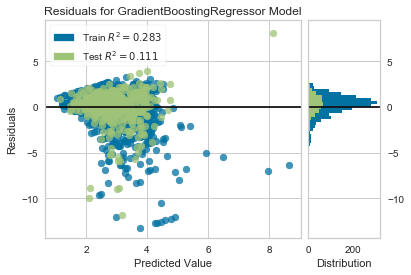

In [23]:
visualizer = ResidualsPlot(gb_grid.best_estimator_)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

Even though this model is more likely to over-predict the convenience to grocery store ratio, the largest residuals are from very large under-predictions.

Throughout this analysis, I have been using test data to compare models. Now that I am done comparing models, I will use the final holdout set to evaluate the final model.

In [24]:
y_pred = np.full_like(y_final, y_train.mean())
print(math.sqrt(mean_squared_error(y_final, y_pred)))

2.4878948152705957


In [25]:
rmse_score(gb_grid.best_estimator_, X_final, y_final)

2.3284798827668083

In [26]:
y_final.std()

2.4846058600714493

This RMSE appears to be much worse, but as a percent of the standard deviation, theRMSE is similar to that of the test set.  
I will look at the reiduals plot for this test set as well.

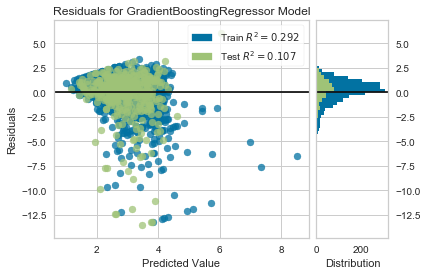

In [27]:
visualizer = ResidualsPlot(gb_grid.best_estimator_)
visualizer.fit(X_train, y_train)
visualizer.score(X_final, y_final)
visualizer.poof()

Even though the RMSE is much worse for the 'final' holdout set compared to the 'test' holdout, the $R^2$ value and distribution of residuals is similar. The difference appears to be that the 'final' holdout set contains more counties where this model under-predicts by a wide margin.

In [28]:
y_pred = gb_grid.best_estimator_.predict(X)
y_pred = pd.DataFrame(y_pred, index=y.index)
predictions = pd.DataFrame(y).join(y_pred)
predictions.columns = ['y_true', 'y_pred']
predictions['residuals'] = predictions['y_pred'] - predictions['y_true']
predictions.to_csv('Data/predictions.csv')